In [4]:
import numpy as np
import pandas as pd
import datetime

In [5]:
# Chargement du fichier dans un dataframe
df = pd.read_csv("MyMoviesDetailsCastingRaw.csv", sep=";", 
                 parse_dates=["viewing_date", "release_date"], 
                 decimal = ",")
# On remplit les vides avec 0
df = df.fillna("0")

# On convertit les types "objets" en entiers ou décimaux selon
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['vote_average'] = df['vote_average'].astype(float)
df['vote_count'] = df['vote_count'].astype(int)
df['personal_rating'] = df['personal_rating'].astype(int)
df['budget'] = df['budget'].astype(float)
df['revenue'] = df['revenue'].astype(float)
df['runtime'] = df['runtime'].astype(int)
df['production_countries_number'] = df['production_countries_number'].astype(int)
df['production_companies_number'] = df['production_companies_number'].astype(int)
df['actor_number'] = df['actor_number'].astype(int)
df['director_number'] = df['director_number'].astype(int)
df['producer_number'] = df['producer_number'].astype(int)
df['genre_number'] = df['genre_number'].astype(int)

# On multiplie mes notes par 2 pour être homogène à une note sur 10
df['personal_rating'] = df['personal_rating']*2

In [6]:
#On vite les colonnes inutiles & les lignes sans ID tmdb donc inexploitables
df.drop(df[df["tmdb_id"]=="0"].index,inplace=True)
df.drop(df[df["director"]=="0"].index,inplace=True)
df.drop("children",axis=1,inplace=True)
df.drop("tmdb_id",axis=1,inplace=True)
df.drop("original_title",axis=1,inplace=True)
df.drop("viewing_date",axis=1,inplace=True)
df.drop("budget",axis=1,inplace=True)
df.drop("revenue",axis=1,inplace=True)
df.drop("imdb_rating",axis=1,inplace=True)
df.drop("imdb_id",axis=1,inplace=True)
df.drop("production_countries_number",axis=1,inplace=True)
df.drop("production_company",axis=1,inplace=True)
df.drop("production_companies_number",axis=1,inplace=True)
df.drop("director_number",axis=1,inplace=True)
df.drop("producer",axis=1,inplace=True)
df.drop("producer_number",axis=1,inplace=True)
df['release_year'] = pd.DatetimeIndex(df['release_date']).year
df.drop("release_date",axis=1,inplace=True)


#On remplace les notes TMDB nulles par la moyenne = 6.84 (<10% des films sont concernés)
df.loc[df["vote_average"]==0,"vote_average"] = 6.8

#On ajoute en attribut le nb de films vus du même directeur (leakage ?)
df2 = df.groupby("director",as_index=False).count().loc[:,["director","title"]]
df2.rename(columns = {'title':'movies_same_director_watched'}, inplace = True)
df=pd.merge(df,df2,on="director")

# Premier essai : ma note binaire ("liked")

In [7]:
#On binarise ma note >5 = j'ai aimé, sinon non
df["liked"]=0
df.loc[df["personal_rating"]>5,"liked"]=1

#On nettoie les dernières colonnes avant l'algo de classif
df.drop("personal_rating",axis=1,inplace=True)
df.drop("director",axis=1,inplace=True)

In [8]:
#Fonction qui permet de mesurer l'importance de la feature dans le fait que j'aime un film ou pas (en %)
def compare(feature,df):
    return df.groupby(feature)["liked"].sum()*100/df.groupby(feature)["liked"].count()

#Fonction pour encoder les features catégorielles (on crée une colonne avec le suffixe_code)
def encode(feature,df) :
    df[feature] = pd.Categorical(df[feature])
    df[feature+"_code"] = df[feature].cat.codes
    return df

In [9]:
#On encore les features de type "catégories"
df = encode("original_language",df)
df = encode("production_country",df)
df = encode("genre",df)

In [10]:
#On splitte le dataset en 2 dataset : 80% pour entrainer le model, 20% pour le test
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.2)

In [18]:
#On entraine l'arbre
from sklearn.tree import DecisionTreeClassifier
features = ['vote_count', 'vote_average','release_year', 'movies_same_director_watched','original_language_code','genre_code']

#On teste le score avec plusieurs noeuds
score=pd.DataFrame(columns=["leaf_nodes","score"])

for i in range(3,100):
    clf = DecisionTreeClassifier(max_leaf_nodes=i)
    clf = clf.fit(train[features],train["liked"])
    #On teste l'accuracy du modèle
    predictions = clf.predict(test[features])
    from sklearn.metrics import accuracy_score
    score.loc[i,"leaf_node"]=i
    score.loc[i,"score"]=accuracy_score(test["liked"],predictions)



#Quel rôle joue chaque feature dans la décision de classification ?
clf.feature_importances_

array([ 0.25165682,  0.28477786,  0.21066986,  0.0909394 ,  0.06972274,
        0.09223332])

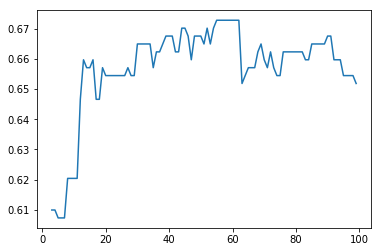

In [19]:
import matplotlib.pyplot as plt
plt.plot(score["leaf_node"],score["score"])
plt.show()

In [13]:
#Affichage de l'arbre
from sklearn import tree
with open("classify.dot","w") as f:
    f=tree.export_graphviz(clf,feature_names=features,out_file=f)
#installer ensuite le programme GRAPHVIZ et ouvrir le fichier classify.dot avec le programme gvedit.exe